In [3]:
import pandas as pd
import numpy as np
from surprise import SVDpp, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from itertools import product
import time

In [4]:
# Load the combined ratings data
ratings = pd.read_csv('combined_ratings.csv')

# Quick check of the data
print(ratings.head())
print(ratings.shape)

   UserID  MovieID  Rating  Timestamp Gender  Age  Occupation Zip-code  \
0       1     1193       5  978300760      F    1          10    48067   
1       1      661       3  978302109      F    1          10    48067   
2       1      914       3  978301968      F    1          10    48067   
3       1     3408       4  978300275      F    1          10    48067   
4       1     2355       5  978824291      F    1          10    48067   

  OccupationDesc   AgeDesc                                   Title  \
0   K-12 student  Under 18  One Flew Over the Cuckoo's Nest (1975)   
1   K-12 student  Under 18        James and the Giant Peach (1996)   
2   K-12 student  Under 18                     My Fair Lady (1964)   
3   K-12 student  Under 18                  Erin Brockovich (2000)   
4   K-12 student  Under 18                    Bug's Life, A (1998)   

                         Genres           RatingDate  RatingYear  
0                         Drama  2000-12-31 22:12:40        2000  


In [8]:
# Create the user-item matrix
user_item_matrix = ratings.pivot_table(
    index='UserID',
    columns='MovieID',
    values='Rating'
)

# Check the shape and preview
print(user_item_matrix.shape)
user_item_matrix

(6040, 3706)


MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Create empty train/test matrices with same shape and NaNs
train_matrix = user_item_matrix.copy() * np.nan
test_matrix = user_item_matrix.copy() * np.nan

In [4]:
# Normalize ratings per user (mean centering)
ratings['Rating_normalized'] = ratings.groupby('UserID')['Rating'].transform(lambda x: x - x.mean())

# Optional: create user demographic features (can be used later for fairness or hybrid filtering)
user_features = ratings[['UserID', 'Gender', 'Age', 'Occupation']].drop_duplicates().set_index('UserID')

In [10]:
# Split each user's ratings
for user_id in user_item_matrix.index:
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings.dropna()

    if len(rated_items) < 44:  # skip users with too few ratings (based on EDA)
        continue

    # Random shuffle
    shuffled = rated_items.sample(frac=1, random_state=42)

    cutoff = int(0.8 * len(shuffled))
    train_items = shuffled.iloc[:cutoff]
    test_items = shuffled.iloc[cutoff:]

    # Assign ratings back to correct movie columns
    train_matrix.loc[user_id, train_items.index] = train_items.values
    test_matrix.loc[user_id, test_items.index] = test_items.values

In [11]:
# Double checks
# Total number of ratings check
original_count = (~user_item_matrix.isna()).sum().sum()
train_count = (~train_matrix.isna()).sum().sum()
test_count = (~test_matrix.isna()).sum().sum()

print(f"Original rating count: {original_count}")
print(f"Train rating count:    {train_count}")
print(f"Test rating count:     {test_count}")
print(f"Total (train + test):  {train_count + test_count}")
print("Rating count preserved:", original_count == train_count + test_count)

# Overlap check
overlap = (~train_matrix.isna()) & (~test_matrix.isna())
overlap_count = overlap.sum().sum()
print(f"Overlapping ratings in train and test: {overlap_count}")  # Should be 0
print("No overlap between train and test:", overlap_count == 0)

Original rating count: 1000209
Train rating count:    762672
Test rating count:     192929
Total (train + test):  955601
Rating count preserved: False
Overlapping ratings in train and test: 0
No overlap between train and test: True


In [12]:
# --- Optional — Convert to long format for SVD++/Surprise ---
train_long = train_matrix.stack().reset_index()
train_long.columns = ['UserID', 'MovieID', 'Rating']

test_long = test_matrix.stack().reset_index()
test_long.columns = ['UserID', 'MovieID', 'Rating']

In [13]:
train_long

,UserID,MovieID,Rating
0,1,1,5.0
1,1,48,5.0
2,1,150,5.0
3,1,260,4.0
4,1,527,5.0
...,...,...,...
762667,6040,3547,4.0
762668,6040,3552,2.0
762669,6040,3683,4.0
762670,6040,3703,4.0


In [14]:
test_long

,UserID,MovieID,Rating
0,1,594,4.0
1,1,661,3.0
2,1,914,3.0
3,1,1028,5.0
4,1,1035,5.0
...,...,...,...
192924,6040,3521,5.0
192925,6040,3543,4.0
192926,6040,3671,4.0
192927,6040,3751,4.0


In [14]:
# --- Step 1: Create reader and load train data ---
reader = Reader(rating_scale=(1, 5))
train_data_dataset = Dataset.load_from_df(train_long[['UserID', 'MovieID', 'Rating']], reader)

# Build the full trainset from your custom training data
full_trainset = train_data_dataset.build_full_trainset()

In [15]:
# --- Step 2: Use test_long as your custom test set ---
# Surprise needs testset in format: [(uid, iid, true_rating)]
custom_testset = list(test_long.itertuples(index=False, name=None))  # (UserID, MovieID, Rating)

In [13]:
# --- Step 3: (Optional) Split training into smaller train/validation set for tuning ---
# Re-wrap full trainset into DataFrame
train_df_for_tuning = pd.DataFrame(full_trainset.build_testset(), columns=['UserID', 'MovieID', 'Rating'])

# Load it into a new dataset and split it for tuning
tuning_data = Dataset.load_from_df(train_df_for_tuning, reader)
smaller_trainset, validation_set = train_test_split(tuning_data, test_size=0.2, random_state=42)

In [15]:
# Grid Search over SVD++ parameters
param_grid = {
    'n_factors': [10, 20, 30],
    'n_epochs': [5, 10, 20],
    'lr_all': [0.005, 0.007],
    'reg_all': [0.1]
}

best_rmse = float('inf')
best_params = None

# Get total combinations for progress logging
keys, values = zip(*param_grid.items())
total_combinations = len(list(product(*values)))
combo_count = 1

print(f"Starting grid search over {total_combinations} combinations...\n")

for combo in product(*values):
    params = dict(zip(keys, combo))
    print(f"[{combo_count}/{total_combinations}] Training with params: {params}")
    start_time = time.time()

    # Train model
    model = SVDpp(**params, random_state=42, verbose=False)
    model.fit(smaller_trainset)

    # Predict on validation set
    predictions = model.test(validation_set)
    rmse = accuracy.rmse(predictions, verbose=False)

    elapsed = time.time() - start_time
    print(f"Completed in {elapsed:.2f} seconds — RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        print(f"New best RMSE, (was {best_rmse:.4f})")
        best_rmse = rmse
        best_params = params

    print("-" * 50)
    combo_count += 1

print(f"\nGrid search complete. Best RMSE: {best_rmse:.4f}")
print(f"Best parameters: {best_params}")

Starting grid search over 18 combinations...

[1/18] Training with params: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.1}
Completed in 110.51 seconds — RMSE: 0.9146
New best RMSE, (was inf)
--------------------------------------------------
[2/18] Training with params: {'n_factors': 10, 'n_epochs': 5, 'lr_all': 0.007, 'reg_all': 0.1}
Completed in 96.19 seconds — RMSE: 0.9127
New best RMSE, (was 0.9146)
--------------------------------------------------
[3/18] Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.1}
Completed in 136.74 seconds — RMSE: 0.9096
New best RMSE, (was 0.9127)
--------------------------------------------------
[4/18] Training with params: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.007, 'reg_all': 0.1}
Completed in 130.84 seconds — RMSE: 0.9053
New best RMSE, (was 0.9096)
--------------------------------------------------
[5/18] Training with params: {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all

In [16]:
final_model = SVDpp(
    n_factors=30,
    n_epochs=20,
    lr_all=0.007,
    reg_all=0.1,
    random_state=42,
    verbose=False
)

In [18]:
final_model.fit(full_trainset)

In [19]:
predictions = final_model.test(custom_testset)
rmse = accuracy.rmse(predictions, verbose=True)
print(f"Final SVD++ RMSE on test set: {rmse:.4f}")

RMSE: 0.8830
Final SVD++ RMSE on test set: 0.8830


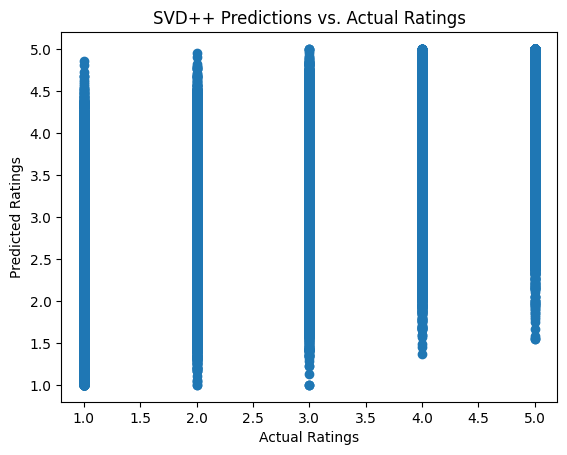

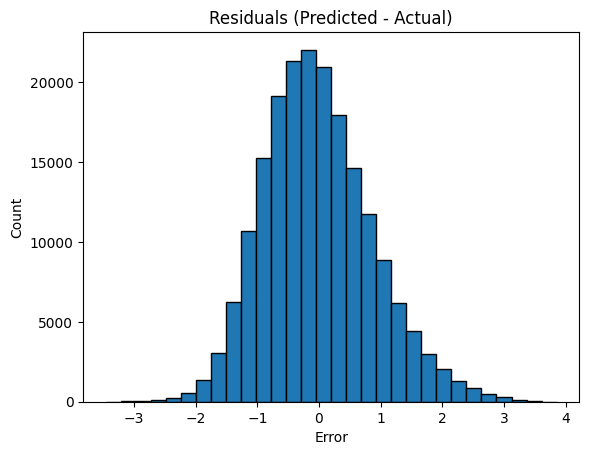

In [22]:
# Extract actual (true) and predicted ratings
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

# 1) Scatter plot of actual vs. predicted
plt.scatter(actual_ratings, predicted_ratings)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("SVD++ Predictions vs. Actual Ratings")
plt.show()

# 2) Histogram of residuals (predicted - actual)
residuals = [pred.est - pred.r_ui for pred in predictions]
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residuals (Predicted - Actual)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()